# Asian Option pricing using quantum algorithm for Monte Carlo on Amazon Braket.

In this notebook we will implement a simple educational example of performing Quantum Monte carlo estimation of Asian call option on Amazon Braket using Pennylane's `QuantumMonteCarlo` module and `lightning.default` simulator.

First we begin by importing Pennylane and supporting modules for analysis and plotting.

In [1]:
import pennylane as qml
import numpy as np
import scipy
import scipy.stats
import itertools
from time import time
import matplotlib.pyplot as plt

### Define Asian call option

Let's define parameters of the Asian option: The initial value of the asset price today called the spot price (`S0`), the strik price (`K`), the risk free rate (`r`), volatility (`sigma`) and the maturity time in years (`T`) with number of `periods` for averaging.

In [2]:
S0 = 100  # spot price
K = 100  # strike price
r = 0.05  # risk free rate
sigma = 0.2  # volatility
T = 1  # time (e.g. in years)
periods = 2

We will use a normal distribution, charaterized by zero mean and `variance` to mimic the probability distrbution underlying the asset. This is an assumption for demonstration purposes in this notebook. One can consider variety of other probability distribution. We have defined a `cutoff_factor` which determins the sprad of the distribution being consider in the simualtion. 

In [3]:
variance = 1 # Variance of the Normal Distribution being used.
cutoff_factor = 4

### Parameters of QMC:
Number of discretization qubits: `n_disc`

Number of phase estimation qubits: `n_pe'

In [4]:
n_disc = 4
n_pe = 5

# Payoff function: Asian Call

In [5]:
def asian_payoff_func(spot, strike, rate, volatility, time, x):
    combinations = itertools.product(x)
    Dt = time / periods
    payoffs = []
    for item in x:
        price = [spot]
        price.append(price[-1] * np.exp(volatility * item
                                            + (rate - 0.5 * volatility ** 2) * Dt))
        price = np.expand_dims(np.array(price[1:]), axis=0)
        payoff = asian_call_payoffs(price, strike, spot)[0]
        payoffs.append(payoff)
    if np.max(payoffs) == 0:
        payoffs[0] = 1e-10
    return np.array(payoffs)*np.exp(- rate * time)

def asian_call_payoffs(paths, strike, spot, payoff_type = 'geometric'):
    spots = np.full((paths.shape[0], 1), spot)
    paths = np.append(spots, paths, axis=1)
    
    if payoff_type == 'geometric':
        means = scipy.stats.mstats.gmean(paths, axis=1)
    elif payoff_type == 'arithmetic':
        means = np.mean(paths, axis=1)
    else:
        raise Exception('Error: payoff_type must be either geometric or arithmetic')
    asian_payoffs = means - strike
    asian_payoffs[asian_payoffs < 0] = 0

    return asian_payoffs

Probability distribution

In [6]:
def normal_dist(n, variance, cutoff_factor):
    dim = 2 ** n
    cutoff_tmp = cutoff_factor * np.sqrt(variance)
    points = np.linspace(-cutoff_tmp, cutoff_tmp, num=dim)
    prob = (1 / np.sqrt(2 * np.pi * variance)) * np.exp(- 0.5 * points ** 2 / variance)
    prob_renorm = prob / np.sum(prob)
    return [points, prob_renorm]

In [7]:
def QMC_Asian_call(spot=100, strike=100, rate=0.05, volatility=0.2, time=1, 
                   variance=1.0, cutoff_factor=4, n_disc=4, n_pe=10):

    N_disc, N_pe = 2**n_disc, 2**n_pe
    
    x, p = normal_dist(n_disc, T, cutoff_factor)
    asian_payoff = asian_payoff_func(spot, strike, rate, volatility, time, x)
    normalization_factor = max(asian_payoff)
    payoff_func = lambda i: asian_payoff[i]/normalization_factor
    
    target_wires = range(n_disc+1)
    estimation_wires = range(n_disc+1, n_disc+n_pe+1)
    
    dev = qml.device("lightning.qubit", wires=(n_disc+n_pe+1))    
    @qml.qnode(dev)
    def circuit():
        qml.templates.QuantumMonteCarlo(
            p,
            payoff_func,
            target_wires=target_wires,
            estimation_wires=estimation_wires,
        )
        return qml.probs(estimation_wires)
    
    phase_estimated = np.argmax(circuit()[:int(N_pe / 2)]) / N_pe
    
    estimated_value_qmc = (1 - np.cos(np.pi * phase_estimated)) / 2 * normalization_factor
        
    return np.array(estimated_value_qmc)

# Benchmarking

Determine the option price with the default values chosen in the previous cell.

In [8]:
t1 = time()
results = QMC_Asian_call()
t2 = time()
print('Results: ', results, "time: ", t2 - t1)

Results:  4.492103185359647 time:  0.1625213623046875


We now compute the prices for varying values of `n_disc`:

In [9]:
def asian_qmc_price(n_d):
    npe = range(4, 17)
    time_npe = []
    price_npe = []
    for n_pe in npe:
        t1 = time()
        price_npe.append(QMC_Asian_call(n_disc=n_d, n_pe=n_pe))
        t2 = time()
        time_npe.append(t2-t1)
        print('nd {} and npe:'.format(n_d), n_pe, 'time:', t2-t1)
    return price_npe, time_npe


In [10]:
n_d = np.arange(2, 7)
prices = []
for n in n_d:
    prices.append(asian_qmc_price(n))

nd 2 and npe: 4 time: 0.015489816665649414
nd 2 and npe: 5 time: 0.010204076766967773
nd 2 and npe: 6 time: 0.011983156204223633
nd 2 and npe: 7 time: 0.013401508331298828
nd 2 and npe: 8 time: 0.026195049285888672
nd 2 and npe: 9 time: 0.017522573471069336
nd 2 and npe: 10 time: 0.022644996643066406
nd 2 and npe: 11 time: 0.027524709701538086
nd 2 and npe: 12 time: 0.06668448448181152
nd 2 and npe: 13 time: 0.13380646705627441
nd 2 and npe: 14 time: 0.21270990371704102
nd 2 and npe: 15 time: 0.1861410140991211
nd 2 and npe: 16 time: 0.34830141067504883
nd 3 and npe: 4 time: 0.018967390060424805
nd 3 and npe: 5 time: 0.01843738555908203
nd 3 and npe: 6 time: 0.017141342163085938
nd 3 and npe: 7 time: 0.017918109893798828
nd 3 and npe: 8 time: 0.018619060516357422
nd 3 and npe: 9 time: 0.04207468032836914
nd 3 and npe: 10 time: 0.04950070381164551
nd 3 and npe: 11 time: 0.04571175575256348
nd 3 and npe: 12 time: 0.07075619697570801
nd 3 and npe: 13 time: 0.17410778999328613
nd 3 and npe

In [36]:
#price for n_d = 4
price_nd4 = prices[2][0]
price_nd6 = prices[4][0]

npe = range(4, 17)
N_QMC = [2**item for item in npe]
error_nd4 = [np.abs((price_nd4[-1]-item))/K for item in price_nd4]
error_nd6 = [np.abs((price_nd6[-1]-item))/K for item in price_nd6]

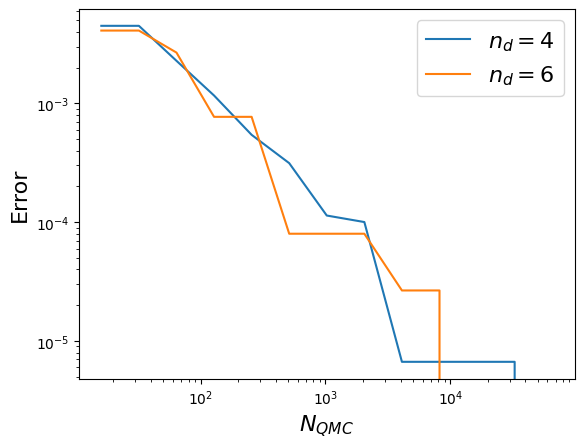

In [39]:
plt.plot(N_QMC, error_nd4)
plt.plot(N_QMC, error_nd6)
plt.legend([r'$n_d=4$', r'$n_d=6$'], fontsize=16)
plt.xlabel(r"$N_{QMC}$", fontsize=16)
plt.ylabel(r"Error", fontsize=16)
plt.yscale('log')
plt.xscale('log')

Now let's determin the scaling exponent by fitting to a power law.

In [40]:
from scipy.optimize import curve_fit

In [41]:
def log_powerlaw(x, A, B):
    y = A + B*x
    return y

In [64]:
fitparams = []
xdata = [2**item for item in npe]
for idx, n in enumerate(n_d):
    ydata_tmp = np.array([prices[idx][0][i] for i in range(len(xdata))])
    ydata = np.abs(ydata_tmp - ydata_tmp[-1])
    fitparams.append(curve_fit(log_powerlaw, np.log(xdata[:-4]), np.log(ydata[:-4])))

Quantum scaling exponents:

In [75]:
zeta_q = [fitparams[i][0][-1] for i in range(len(fitparams))]
A_q = [fitparams[i][0][0] for i in range(len(fitparams))]
zeta_q_delta = [fitparams[i][-1][-1][-1] for i in range(len(fitparams))]

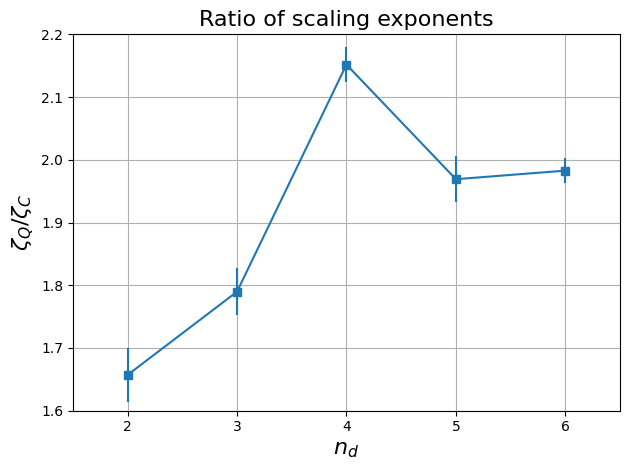

In [69]:
# plt.plot(n_d, np.array(zeta_q), linewidth=4)
plt.errorbar(n_d, 2*np.abs(np.array(zeta_q)), yerr=2*np.abs(zeta_q_delta), marker='s')
# plt.plot(n_d, np.array(zeta_q), linewidth=4)
plt.ylim([1.6,2.2])
plt.xlim([1.5,6.5])
plt.title("Ratio of scaling exponents", fontsize=16)
plt.ylabel(r"$\zeta_Q/\zeta_C$", fontsize=16)
plt.xlabel(r"$n_d$", fontsize=16)
plt.grid()
plt.tight_layout()
plt.savefig("quadratic_scaling_asian_zeta.png")

Walltime of simulations

In [70]:
timings = [prices[i][1] for i in range(len(prices))]

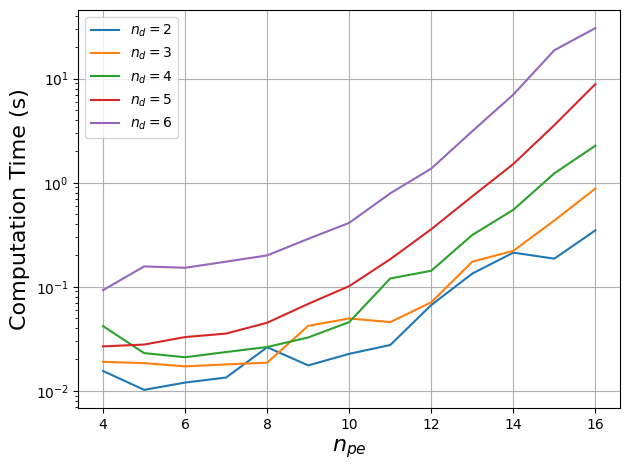

In [71]:
# plt.plot(n_d, np.array(zeta_q), linewidth=4)
for i, timedata in enumerate(timings):
    plt.plot(npe, timedata)
plt.ylabel(r"Computation Time (s)", fontsize=16)
plt.xlabel(r"$n_{pe}$", fontsize=16)
plt.legend([r"$n_d= 2$", r"$n_d= 3$", r"$n_d= 4$", r"$n_d= 5$", r"$n_d= 6$"])
plt.yscale('log')
plt.tight_layout()
plt.grid()
plt.savefig("quadratic_scaling_asian_time.png")

Comparing run for `n_d = 6`

In [101]:
fit6 = np.exp(A_q[-1] + zeta_q[-1] * np.log(np.array(xdata)))
classical_scaling = np.exp(A_q[-1] -0.5 * np.log(np.array(xdata)))

In [102]:
error_nd6 = prices[-1][0] -prices[-1][0][-1]

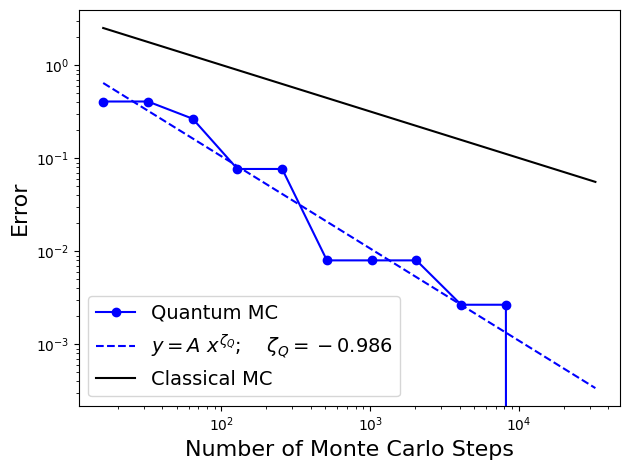

In [103]:
plt.plot(xdata[:-2], np.abs(e_nd6[:-2]), 'o-', color='blue')
plt.plot(xdata[:-1], fit6[:-1], '--', color='blue')
plt.plot(xdata[:-1], classical_scaling[:-1], '-', color='black')
plt.xscale('log')
plt.yscale('log')
plt.legend([r"Quantum MC", r"$y = A~x^{\zeta_Q}$; $~~~\zeta_Q=-0.986$", "Classical MC"], fontsize=14)
plt.xlabel("Number of Monte Carlo Steps", fontsize=16)
plt.ylabel("Error", rotation=90, fontsize=16)
plt.tight_layout()
plt.savefig("quadratic_scaling_asian.png")